# BAX 452 Machine Learning HW2 Code

# Import & Clean Data

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import mne
from mne.stats import bonferroni_correction, fdr_correction

In [2]:
# import google.colab
# from google.colab import files
# uploaded = files.upload()

In [4]:
income = pd.read_csv(r"D:/Winter 2020/BAX 452 Machine Learning/Homework 2/income_data.csv", sep=r'\s*,\s*', engine='python')

In [5]:
#clean the variable name 
income['marital_status'] = income['marital-status']
income['education_num'] = income['education-num']
income['capital_gain'] = income['capital-gain']
income['capital_loss'] = income['capital-loss']
income['hours_per_week'] = income['hours-per-week']
income['native_country'] = income['native-country']
unclean_names = ['marital-status', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
income = income.drop(unclean_names, 1)

In [6]:
#merging levels of education
income['education']=np.where(income['education'] =='11th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='9th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='7th-8th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='5th-6th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='10th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='1st-4th', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='Preschool', 'Not-HS-Grad', income['education'])
income['education']=np.where(income['education'] =='12th', 'Not-HS-Grad', income['education'])

In [7]:
income_raw = income.copy()

# EDA

## Part 1. Y = whether income > 50k

**1) Occupation**    
    a. Exec-managerial occupation shows more even distribution for people earn over 50k and under 50k.   
    b. people work in the adm-clerical, other-service, sales, craft-repaire field show large disparency of income level.

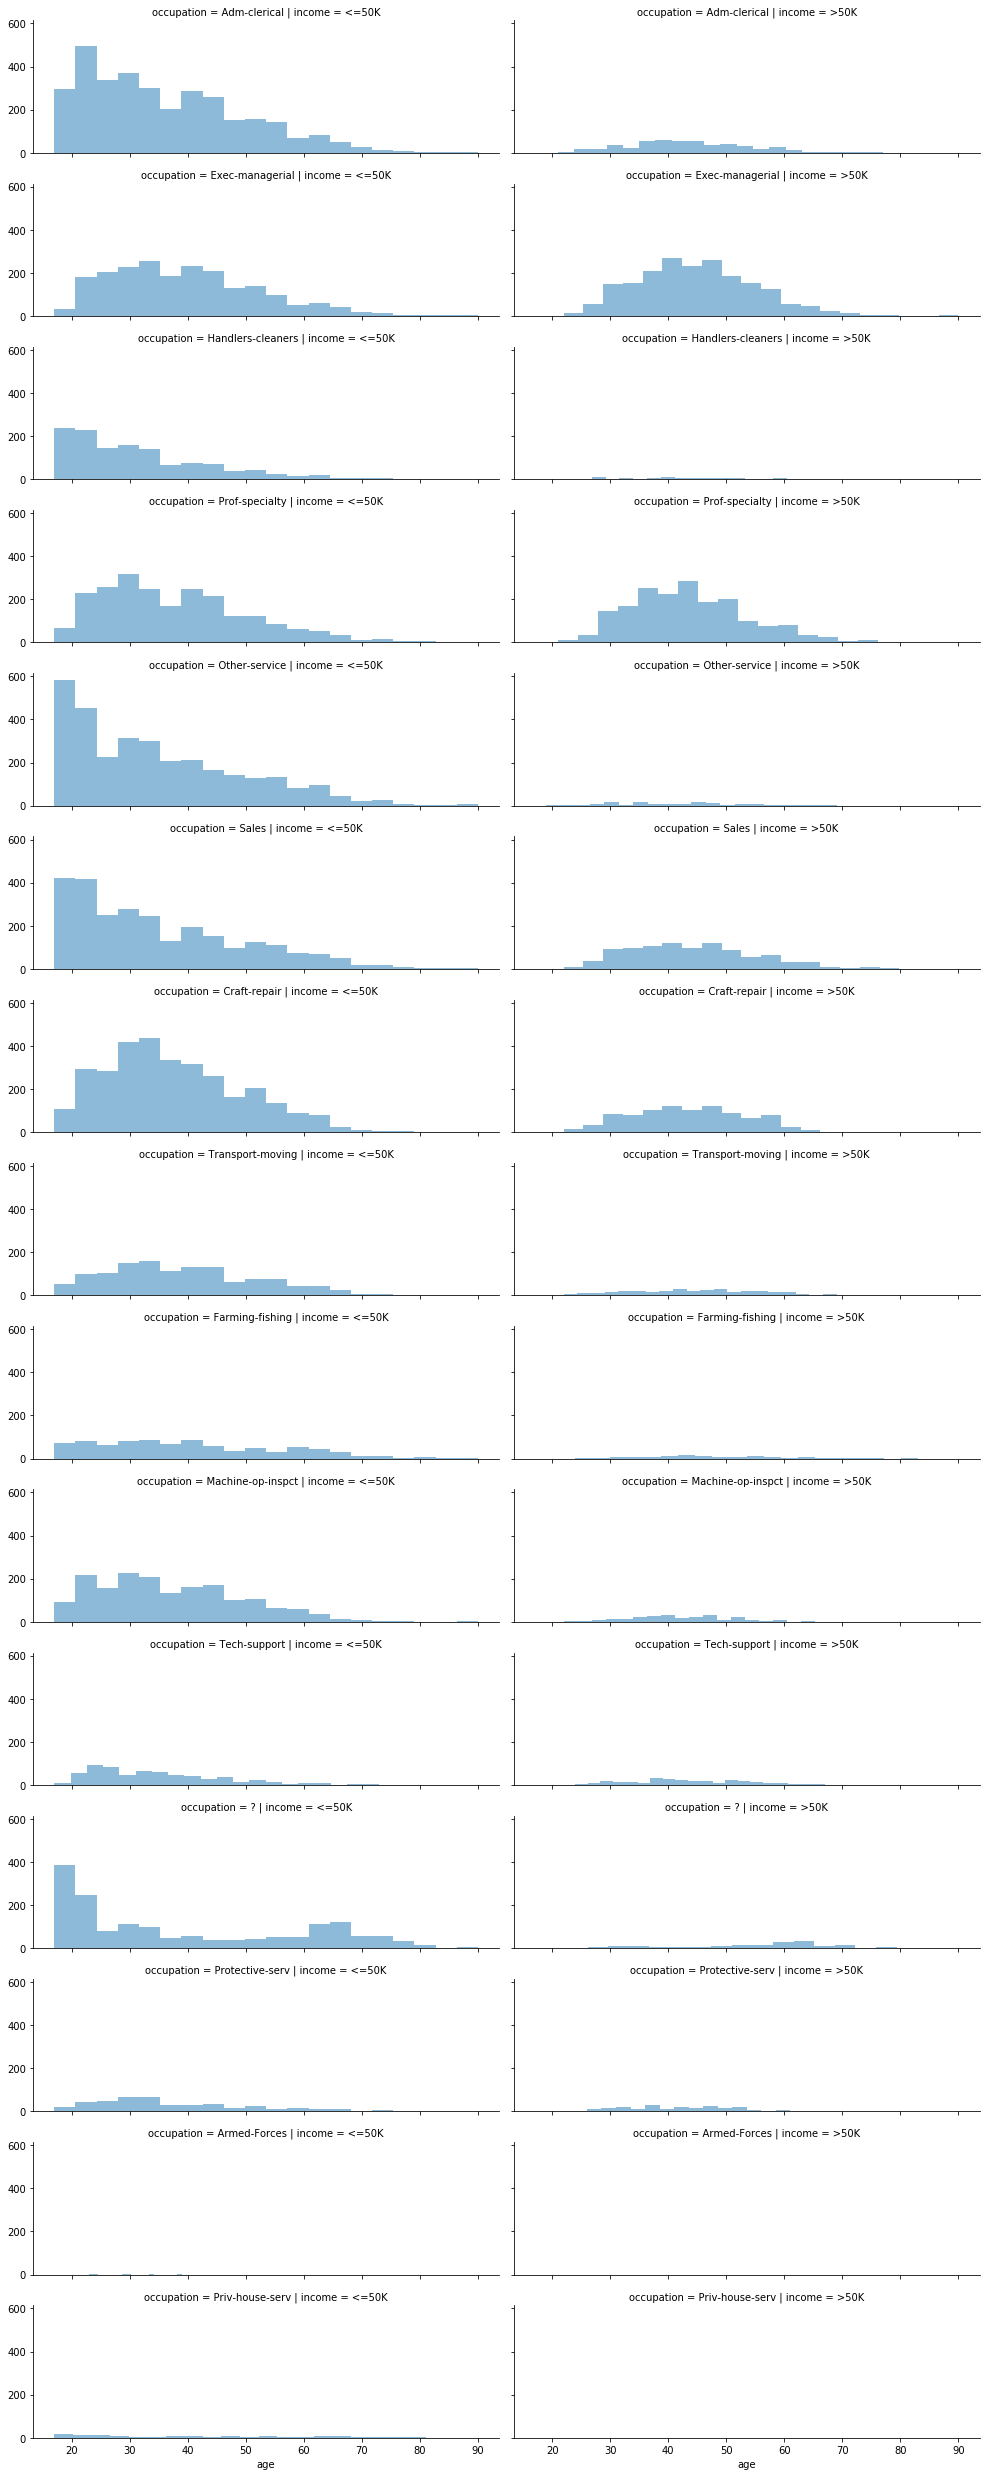

In [8]:
grid = sns.FacetGrid(income, col='income', row='occupation',height=2.3, aspect=3)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

**2) Age**  
Age of people with income over 50k are normally distributed, centered on middle age - 40 to 45 years old.   
Age distribution of people with income less than 50k are right skewed. 


Text(0.5, 0, 'Age')

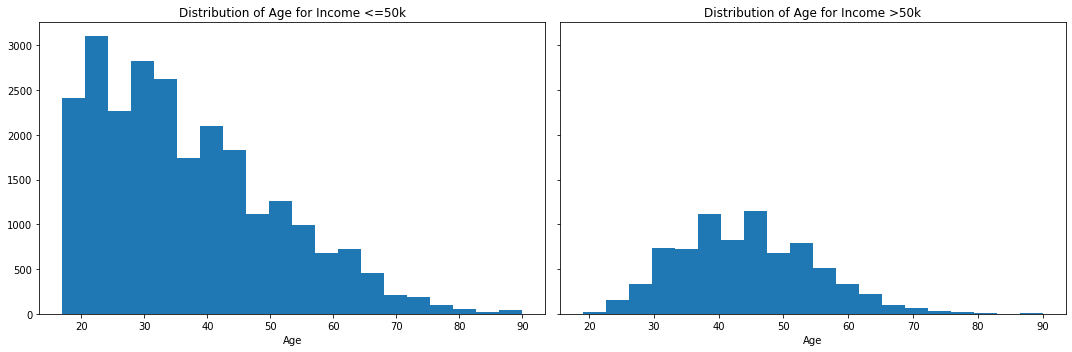

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (15,5))

axs[0].hist(income[income["income"] == "<=50K"]["age"], bins=20)
axs[0].set_title("Distribution of Age for Income <=50k")
axs[0].set_xlabel("Age")
axs[1].hist(income[income["income"] == ">50K"]["age"], bins=20)
axs[1].set_title("Distribution of Age for Income >50k")
axs[1].set_xlabel("Age")

In [10]:
income.groupby('income')['age'].mean()

income
<=50K    36.783738
>50K     44.249841
Name: age, dtype: float64

**3) Education Level**

Education level plays an important role in terms of its effect on whether people can earn over 50k. But the effect dramatally decreases when reaching the level of master degree.

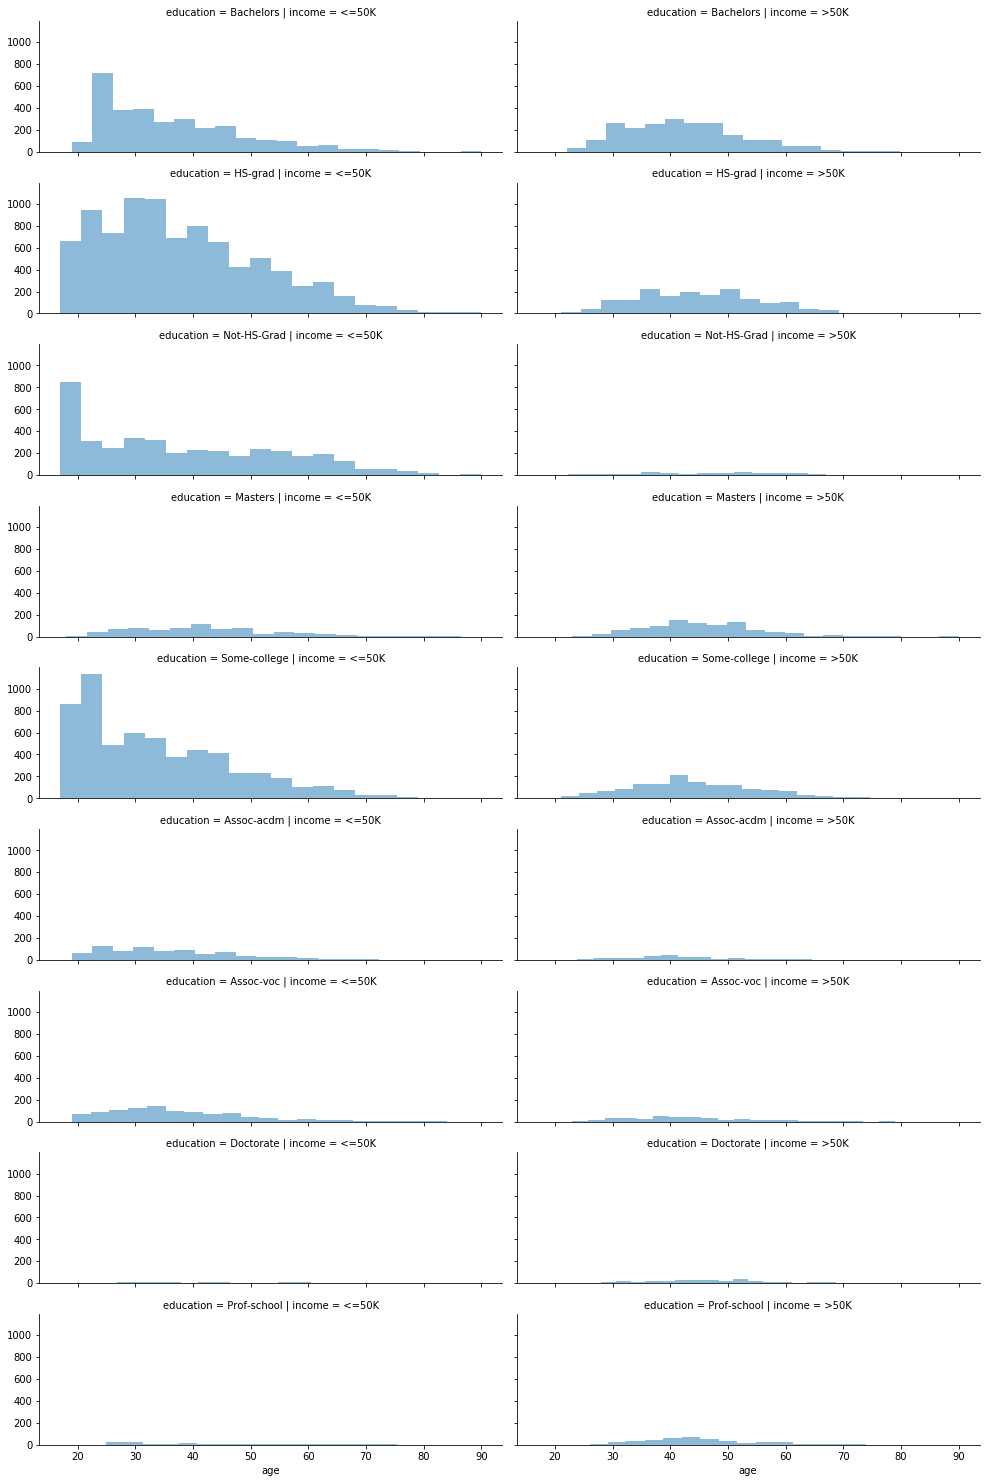

In [11]:
grid = sns.FacetGrid(income, col='income', row='education', height=2.3, aspect=3)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

**4) Working Hours**  
Working overtime -> income >50k

Text(0.5, 0, 'Weekly Working Hours')

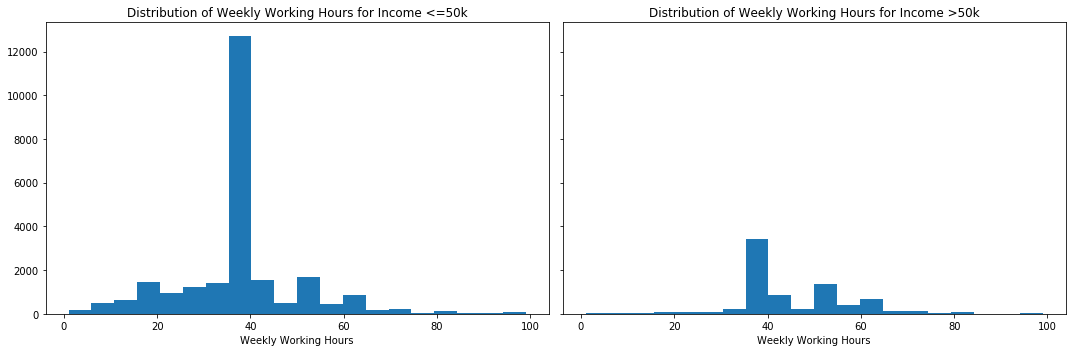

In [12]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (15,5))

axs[0].hist(income[income["income"] == "<=50K"]["hours_per_week"], bins=20)
axs[0].set_title("Distribution of Weekly Working Hours for Income <=50k")
axs[0].set_xlabel("Weekly Working Hours")
axs[1].hist(income[income["income"] == ">50K"]["hours_per_week"], bins=20)
axs[1].set_title("Distribution of Weekly Working Hours for Income >50k")
axs[1].set_xlabel("Weekly Working Hours")

In [13]:
income.groupby("income").mean()["hours_per_week"]

income
<=50K    38.840210
>50K     45.473026
Name: hours_per_week, dtype: float64

## Part 2. Y = Working Hours per Week

1) Workclass

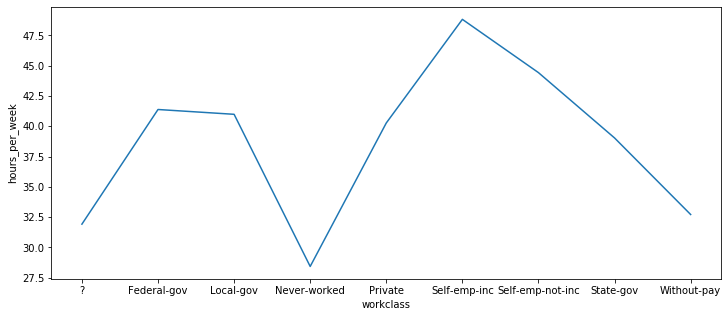

In [14]:
plt.figure(figsize=(12,5))
grp_class=income.groupby('workclass')['hours_per_week'].mean().reset_index()
sp=sns.lineplot(
    x='workclass',
    y='hours_per_week',
    data=grp_class)
sp

In [15]:
income[income['workclass'] != "?"].groupby('workclass')['hours_per_week'].mean()

workclass
Federal-gov         41.379167
Local-gov           40.982800
Never-worked        28.428571
Private             40.267096
Self-emp-inc        48.818100
Self-emp-not-inc    44.421881
State-gov           39.031587
Without-pay         32.714286
Name: hours_per_week, dtype: float64

2) Education

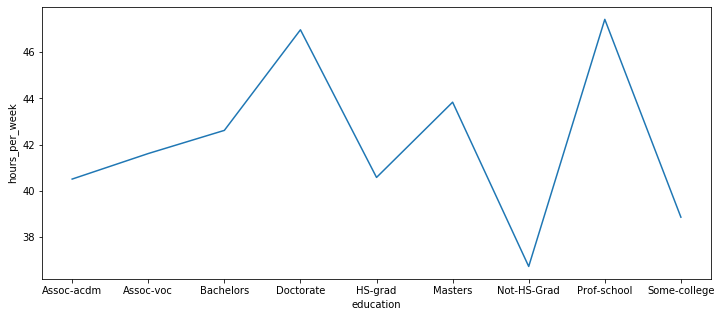

In [16]:
plt.figure(figsize=(12,5))
grp_edu=income.groupby('education')['hours_per_week'].mean().reset_index()
sp1=sns.lineplot(
    x='education',
    y='hours_per_week',
    data=grp_edu)
sp1

In [17]:
income.groupby('education')['hours_per_week'].mean()

education
Assoc-acdm      40.504217
Assoc-voc       41.610709
Bachelors       42.614006
Doctorate       46.973366
HS-grad         40.575374
Masters         43.836332
Not-HS-Grad     36.717846
Prof-school     47.425347
Some-college    38.852284
Name: hours_per_week, dtype: float64

# Feature Elimination
### Part 1. Elimination by EDA
**1) Investment**  
Compared to those who did not investment at all, people had either 'Capital-gain' or 'Capital-loss' are more likely to earn 50k or more. One possible explanation is that only those people with higher income have the ability and resources to make investment. 


### Part 1. Elimination by EDA

**1) Investment**  
Compared to those who did not investment at all, people had either 'Capital-gain' or 'Capital-loss' are more likely to earn 50k or more. One possible explanation is that only those people with higher income have the ability and resources to make investment. 


In [18]:
# Tranform Capital Loss & Capital Gain into Logical variable
income['boolean_capital_gain'] = np.where((income["capital_gain"] == 0), "Zero Gain", "Gain")
income['boolean_capital_loss'] = np.where((income["capital_loss"] == 0), "Zero Loss", "Loss")

Text(0, 0.5, '')

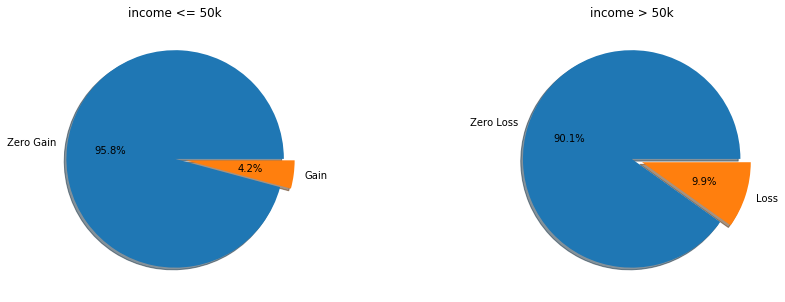

In [19]:
# Capital-Gain vs. High Income
f,ax=plt.subplots(1,2,figsize=(15,5))
income[income["income"] == "<=50K"]["boolean_capital_gain"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('income <= 50k')
ax[0].set_ylabel('')
income[income["income"] == ">50K"]["boolean_capital_loss"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('income > 50k')
ax[1].set_ylabel('')

Text(0, 0.5, '')

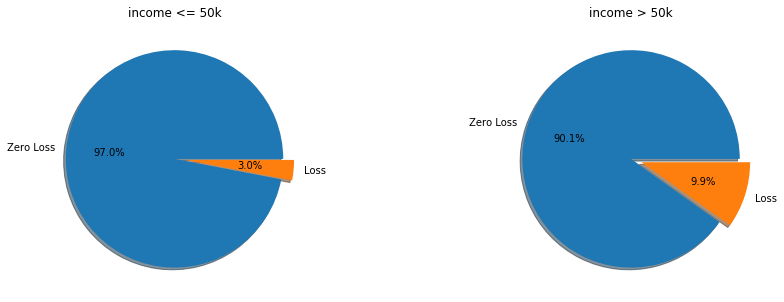

In [20]:
# Capital-Loss vs. High Income
f,ax=plt.subplots(1,2,figsize=(15,5))
income[income["income"] == "<=50K"]["boolean_capital_loss"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('income <= 50k')
ax[0].set_ylabel('')
income[income["income"] == ">50K"]["boolean_capital_loss"].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[1].set_title('income > 50k')
ax[1].set_ylabel('')

Text(0, 0.5, 'High Income')

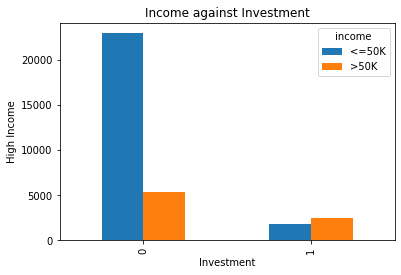

In [21]:
# Combined Capital-Gain & Loss to create new variable 'Invenstment' - whether people invested or not
income['investment'] = np.where(((income["capital_gain"] == 0) & (income["capital_loss"] == 0)), 0, 1)
pd.crosstab(income['investment'],income['income']).plot(kind='bar')
plt.title('Income against Investment')
plt.xlabel('Investment')
plt.ylabel('High Income')

**2) Choice between Education Level vs Years of Education**  
They two are highly correlated. So we chose enducation level, which has lesser levels. 

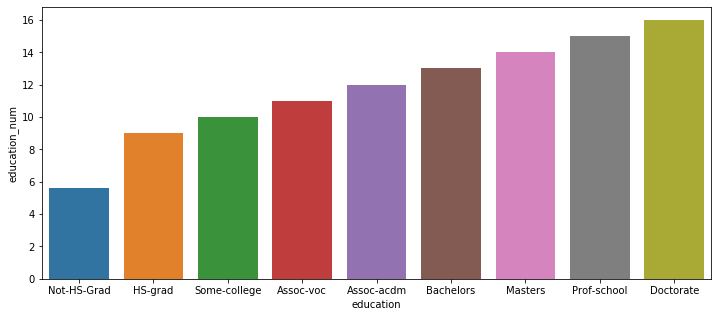

In [22]:
grp_edu=income.groupby('education').mean().reset_index()
# reorder the education level
order_edu = ["Not-HS-Grad", "HS-grad", "Some-college", "Assoc-voc", "Assoc-acdm", "Bachelors", "Masters", "Prof-school", "Doctorate"]

plt.figure(figsize=(12,5))

edu =sns.barplot(
    x='education',
    y='education_num',
    data=grp_edu,
    order = order_edu)
edu

**3) Race**  
Unbalanced Data - drop race


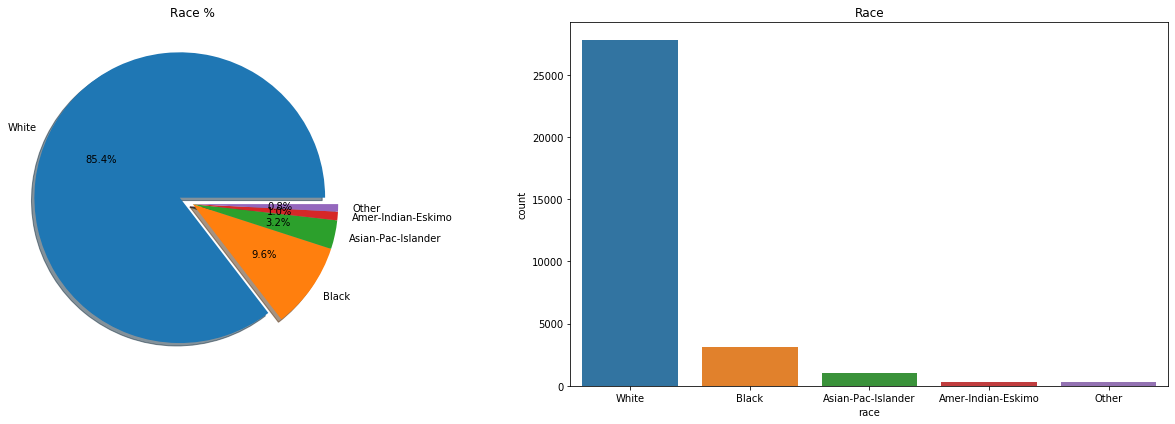

In [23]:
f,ax=plt.subplots(1,2,figsize=(18,6), tight_layout=True)
income['race'].value_counts().plot.pie(explode=[0.1,0,0,0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Race %')
ax[0].set_ylabel('')
sns.countplot('race',data=income,ax=ax[1])
ax[1].set_title('Race')
plt.show()

**4) Native_country**  
Unbalanced Data - drop Native_country

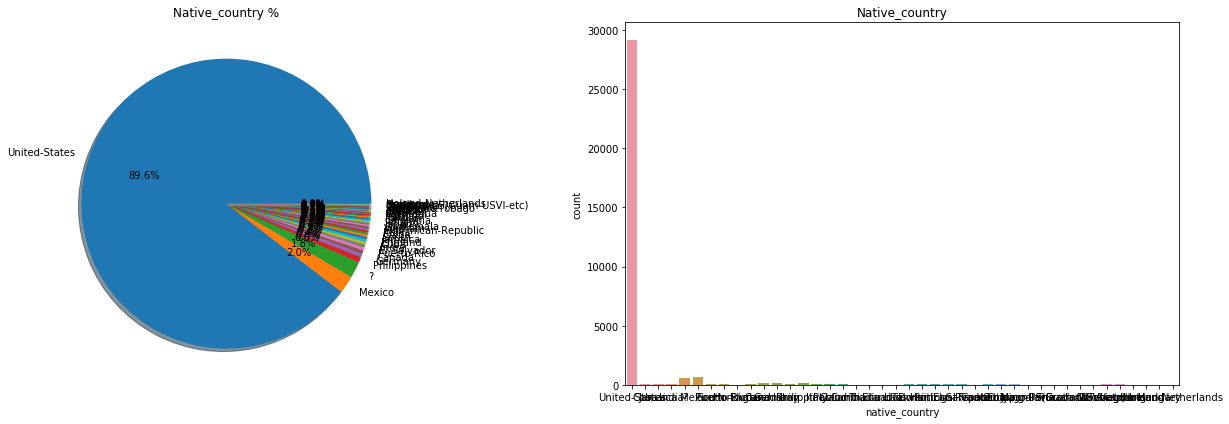

In [24]:
f,ax=plt.subplots(1,2,figsize=(18,6), tight_layout=True)
income['native_country'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Native_country %')
ax[0].set_ylabel('')
sns.countplot('native_country',data=income,ax=ax[1])
ax[1].set_title('Native_country')
plt.show()

### Part 2. Recursive Feature Elimination

**1) clean data based on EDA**  

In [25]:
# relevel education variable and change it to ordinal factor 
mapper = {'Not-HS-Grad':1,'HS-grad':2,'Some-college':3,"Assoc-voc":4,"Assoc-acdm":5,"Bachelors":6,"Masters":7, "Prof-school":8, "Doctorate":9}
income_raw['ordedu'] = income_raw['education'].map(mapper)

In [26]:
income_raw['investment'] = np.where(((income_raw["capital_gain"] == 0) & (income_raw["capital_loss"] == 0)), 0, 1)

In [27]:
# assigning levels to the values of categorical variables
factors = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'investment', 'native_country', 'income']
income_raw = income_raw.drop('education', 1)
income_fact = income_raw.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,fnlwgt,occupation,relationship,race,sex,income,marital_status,education_num,capital_gain,capital_loss,hours_per_week,native_country,ordedu,investment
0,39,7,77516,1,1,4,1,0,4,13,2174,0,40,39,6,1
1,50,6,83311,4,0,4,1,0,2,13,0,0,13,39,6,0
2,38,4,215646,6,1,4,1,0,0,9,0,0,40,39,2,0
3,53,4,234721,6,0,2,1,0,2,7,0,0,40,39,1,0
4,28,4,338409,10,5,2,0,0,2,13,0,0,40,5,6,0


In [28]:
y = income_fact[['income']]
X = income_fact.loc[:, income_fact.columns != 'income']

In [29]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'occupation', 'relationship', 'race',
       'sex', 'marital_status', 'education_num', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country', 'ordedu',
       'investment'],
      dtype='object')

**2) perform RFE**

In [30]:
model = LogisticRegression()
rfe = RFE(model, 10)
fit = rfe.fit(X,y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIM

Num Features: 10
Selected Features: [False  True False False  True  True  True  True  True False False  True
  True  True  True]
Feature Ranking: [2 1 6 3 1 1 1 1 1 5 4 1 1 1 1]


C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Logistic Regression Model

**1) drop features based on feature selection technique**

In [31]:
drop = ['fnlwgt', 'occupation', 'age', 'race', 'capital_gain', 'capital_loss', 'native_country']
income_fact = income_fact.drop(drop,1)

**2) create indicator variables**

In [32]:
df_income = income_fact.copy()
factors1 = ['workclass', 'marital_status', 'relationship', 'sex', 'investment', 'income']
for var in factors1:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df_income[var], prefix=var, drop_first=True)
        df_income = pd.concat([df_income,cat_list], axis = 1)
        df_income = df_income.drop(var, 1)

df_income['income'] = df_income['income'].factorize()[0]
df_income.head()

,income,education_num,hours_per_week,ordedu,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,...,marital_status_4,marital_status_5,marital_status_6,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,sex_1,investment_1
0,0,13,40,6,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
1,0,13,13,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,9,40,2,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,7,40,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,13,40,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


**3) Test-Training Set Split; oversampling using SMOTE**

In [33]:
os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(df_income.drop('income',axis=1),df_income['income'], test_size=0.30, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, Y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['income'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of income less than 50k in oversampled data",len(os_data_y[os_data_y['income']==0]))
print("Number of income more than 50k",len(os_data_y[os_data_y['income']==1]))
print("Proportion of income less than 50k data in oversampled data is ",len(os_data_y[os_data_y['income']==0])/len(os_data_X))
print("Proportion of income more than 50k data in oversampled data is ",len(os_data_y[os_data_y['income']==1])/len(os_data_X))

length of oversampled data is  34626
Number of income less than 50k in oversampled data 17313
Number of income more than 50k 17313
Proportion of income less than 50k data in oversampled data is  0.5
Proportion of income more than 50k data in oversampled data is  0.5


**4) logistic model building**

In [34]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, Y_train)

C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:
Y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(Y_test, Y_pred)
print(confusion_matrix)

[[6810  597]
 [1029 1333]]


In [36]:
print("Accuracy:",logreg.score(X_train, Y_train))
print("Precision:",metrics.precision_score(Y_test, Y_pred))
print("Recall:",metrics.recall_score(Y_test, Y_pred))

Accuracy: 0.834942084942085
Precision: 0.6906735751295336
Recall: 0.5643522438611346


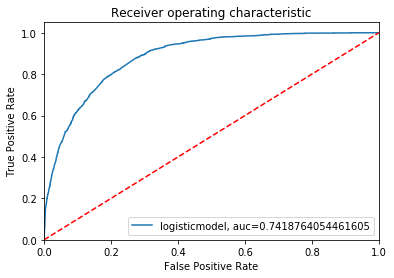

In [37]:
# ROC curve and AUC
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label="logisticmodel, auc="+str(logit_roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [39]:
# Positive coefficients increase the log-odds of the response (and thus increase the probability) 
# negative coefficients decrease the log-odds of the response (and thus decrease the probability).
coeff_df = pd.DataFrame(X_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
from regressors import stats
coeff_df['pvals'] = pd.Series(stats.coef_pval(logreg, X_train, Y_train))

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation,pvals
21,sex_1,1.047701,0.000000
22,investment_1,0.736613,0.000000
3,workclass_2,0.507998,0.000000
7,workclass_6,0.302776,0.017036
12,marital_status_3,0.254890,0.272804
0,hours_per_week,0.227204,0.000000
2,workclass_1,0.148993,0.000000
11,marital_status_2,0.127980,0.423169
4,workclass_3,0.039395,0.000000
1,ordedu,0.028754,0.000000


### Prepared data For Q5,Q6


In [48]:
income_fact = income.copy()
factors = ['workclass', 'education','marital_status','boolean_capital_loss', 'boolean_capital_gain','occupation', 'relationship', 'race', 'sex', 'investment', 'native_country', 'income']
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()

,age,workclass,fnlwgt,education,occupation,relationship,race,sex,income,marital_status,education_num,capital_gain,capital_loss,hours_per_week,native_country,boolean_capital_gain,boolean_capital_loss,investment
0,39,7,77516,2,1,1,4,1,0,4,13,2174,0,40,39,0,1,1
1,50,6,83311,2,4,0,4,1,0,2,13,0,0,13,39,1,1,0
2,38,4,215646,4,6,1,4,1,0,0,9,0,0,40,39,1,1,0
3,53,4,234721,6,6,0,2,1,0,2,7,0,0,40,39,1,1,0
4,28,4,338409,2,10,5,2,0,0,2,13,0,0,40,5,1,1,0


In [49]:
# create indicator variables
df_income = income_fact.copy()
factors1 = ['workclass', 'marital_status', 'education','boolean_capital_loss', 'boolean_capital_gain', "occupation", 'relationship', 'race', 'sex', 'income','native_country']
for var in factors1:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df_income[var], prefix=var, drop_first=True)
        df_income = pd.concat([df_income,cat_list], axis = 1)
        df_income = df_income.drop(var, 1)

df_income['income'] = df_income['income'].factorize()[0]
df_income.head()

,age,fnlwgt,income,education_num,capital_gain,capital_loss,hours_per_week,investment,workclass_1,workclass_2,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
0,39,77516,0,13,2174,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,0,13,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,0,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,0,7,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,0,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
y = df_income[['hours_per_week']]
X = df_income.loc[:, df_income.columns != 'hours_per_week']

### Data used for reduced variables

#### First, Use RFE for the new dependent variable

In [51]:
from sklearn.linear_model import LinearRegression

y_rfe = income_fact[['hours_per_week']]
X_rfe = income_fact.loc[:, income_fact.columns != 'hours_per_week']
model_select_feature = LinearRegression()
rfe = RFE(model_select_feature, 10)
fit = rfe.fit(X_rfe,y_rfe)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))



# drop features due to FDR and RFE
drop = ['fnlwgt', 'capital_gain', 'capital_loss', 'native_country']
income_fact2 = income_fact.drop(drop,1)

# create indicator variables
df_income2 = income_fact2.copy()
factors1 = ['workclass', 'marital_status', 'education', "occupation", 'relationship', 'race', 'sex', 'income']
for var in factors1:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df_income2[var], prefix=var, drop_first=True)
        df_income2 = pd.concat([df_income2,cat_list], axis = 1)
        df_income2 = df_income2.drop(var, 1)

df_income2['income'] = df_income2['income'].factorize()[0]
df_income2.head()


C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Num Features: 10
Selected Features: [False  True False  True False  True  True  True  True  True  True False
 False False False  True  True]
Feature Ranking: [4 1 8 1 3 1 1 1 1 1 1 7 6 5 2 1 1]


,age,income,education_num,hours_per_week,boolean_capital_gain,boolean_capital_loss,investment,workclass_1,workclass_2,workclass_3,...,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,race_1,race_2,race_3,race_4,sex_1
0,39,0,13,40,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
1,50,0,13,13,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,38,0,9,40,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
3,53,0,7,40,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,28,0,13,40,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0



## Question 5

### Fit a Full model and Pick features with P-value>0.05


In [52]:

import statsmodels.api as sm
from scipy import stats

mod = sm.OLS(y,X)
print("We have features : ")
print((X.shape[1]))
fit = mod.fit()
p_values = fit.summary2().tables[1]['P>|t|']

fit.summary()

We have features : 
96


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     87.50
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:35:55   Log-Likelihood:            -1.2437e+05
No. Observations:               32561   AIC:                         2.489e+05
Df Residuals:                   32466   BIC:                         2.497e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
age                       -0.1058      0.006    -17.892      0.000      -0.117      -0.094
fnlwgt                  -2.06e-06   5.97e-07     -3.448      0.001   -3.23e-06   -8.89e-07
income                     3.0198      0.182     16.635      0.000       2.664       3.376
education_num             -0.5881      0.107     -5.501      0.000      -0.798      -0.379
capital_gain            2.881e-05   9.66e-06      2.983      0.003    9.88e-06    4.77e-05
capital_loss               0.0012      0.001      1.583      0.113      -0.000       0.003
investment                22.1011      1.158     19.082      0.000      19.831      24.371
workclass_1                3.8682      0.441      8.776      0.000       3.004       4.732
workclass_2                4.0311      0.379     10.643      0.000       3.289       4.774
workclass_3               -1.7445      4.185     -0.417      0.677      -9.948       6.459
workclass_4                3.9846      0.303     13.172      0.000       3.392       4.577
workclass_5                8.9554      0.439     20.391      0.000       8.095       9.816
workclass_6                5.6672      0.365     15.527      0.000       4.952       6.383
workclass_7                1.9457      0.418      4.655      0.000       1.126       2.765
workclass_8               -2.0215      2.828     -0.715      0.475      -7.565       3.522
marital_status_1           1.4835      2.418      0.614      0.540      -3.256       6.223
marital_status_2           0.2018      0.772      0.261      0.794      -1.311       1.715
marital_status_3          -1.5514      0.573     -2.708      0.007      -2.674      -0.428
marital_status_4          -3.1665      0.229    -13.798      0.000      -3.616      -2.717
marital_status_5          -1.2265      0.386     -3.174      0.002      -1.984      -0.469
marital_status_6          -5.1929      0.402    -12.922      0.000      -5.981      -4.405
education_1                0.1747      0.464      0.377      0.706      -0.734       1.083
education_2                1.4599      0.391      3.738      0.000       0.694       2.225
education_3                6.8985      0.797      8.657      0.000       5.337       8.460
education_4               -1.4399      0.479     -3.006      0.003      -2.379      -0.501
education_5                2.8228      0.496      5.692      0.000       1.851       3.795
education_6               -5.8221      0.770     -7.560      0.000      -7.332      -4.313
education_7                5.3745      0.685      7.850      0.000       4.032       6.716
education_8               -1.8313      0.422     -4.336      0.000      -2.659      -1.003
boolean_capital_loss_1    23.7825      1.165     20.411      0.000      21.499      26.066
boolean_capital_gain_1    22.0803      1.156     19.096      0.000      19.814  

### Leave only important features with p-value <0.05

In [53]:
import statsmodels.api as sm
from scipy import stats

y2 = df_income2[['hours_per_week']]
X2 = df_income2.loc[:, df_income2.columns != 'hours_per_week']

print("We have features : ")
print((X2.shape[1]))

mod2 = sm.OLS(y2,X2)
fit2 = mod2.fit()
p_values2 = fit2.summary2().tables[1]['P>|t|']

fit2.summary()


We have features : 
52


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     162.7
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:36:15   Log-Likelihood:            -1.2441e+05
No. Observations:               32561   AIC:                         2.489e+05
Df Residuals:                   32510   BIC:                         2.493e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
age                     -0.1049      0.006    -17.864      0.000      -0.116      -0.093
income                   3.0730      0.180     17.026      0.000       2.719       3.427
education_num           -0.6274      0.102     -6.165      0.000      -0.827      -0.428
boolean_capital_gain    22.8819      0.865     26.438      0.000      21.186      24.578
boolean_capital_loss    22.7082      0.869     26.116      0.000      21.004      24.412
investment              23.2283      0.872     26.635      0.000      21.519      24.938
workclass_1              3.8725      0.441      8.789      0.000       3.009       4.736
workclass_2              4.0193      0.379     10.614      0.000       3.277       4.762
workclass_3             -1.8094      4.187     -0.432      0.666     -10.017       6.398
workclass_4              3.9883      0.302     13.188      0.000       3.396       4.581
workclass_5              9.0666      0.438     20.677      0.000       8.207       9.926
workclass_6              5.7296      0.365     15.705      0.000       5.014       6.445
workclass_7              1.9103      0.418      4.572      0.000       1.091       2.729
workclass_8             -2.0281      2.830     -0.717      0.474      -7.574       3.518
marital_status_1         1.3686      2.419      0.566      0.572      -3.372       6.110
marital_status_2         0.1289      0.771      0.167      0.867      -1.382       1.639
marital_status_3        -1.4781      0.569     -2.598      0.009      -2.593      -0.363
marital_status_4        -3.1567      0.229    -13.762      0.000      -3.606      -2.707
marital_status_5        -1.2453      0.386     -3.226      0.001      -2.002      -0.489
marital_status_6        -5.1881      0.402    -12.911      0.000      -5.976      -4.400
education_1              0.1683      0.462      0.364      0.716      -0.738       1.074
education_2              1.5231      0.389      3.917      0.000       0.761       2.285
education_3              7.0780      0.782      9.045      0.000       5.544       8.612
education_4             -1.5406      0.469     -3.283      0.001      -2.460      -0.621
education_5              2.9226      0.490      5.959      0.000       1.961       3.884
education_6             -6.0016      0.753     -7.972      0.000      -7.477      -4.526
education_7              5.6782      0.673      8.439      0.000       4.359       6.997
education_8             -1.8940      0.417     -4.538      0.000      -2.712      -1.076
occupation_1             0.7069      0.309      2.290      0.022       0.102       1.312
occupation_2             1.3445      3.531      0.381      0.703      -5.576       8.265
occupation_3             2.1623      0.308      7.016      0.000       1.558       2.766
occupation_4             3.9291      0.310     12.666    

### Regression with Interaction

In [54]:

import statsmodels.formula.api as smf
formula1="hours_per_week~age+workclass+fnlwgt+sex+education+relationship+occupation+education_num+marital_status+race+capital_gain+capital_loss+native_country+income"
model_inter = smf.ols(formula1, data=income)
model_inter = model_inter.fit()

print(formula1)
model_inter.summary()

hours_per_week~age+workclass+fnlwgt+sex+education+relationship+occupation+education_num+marital_status+race+capital_gain+capital_loss+native_country+income


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     89.39
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:36:30   Log-Likelihood:            -1.2437e+05
No. Observations:               32561   AIC:                         2.489e+05
Df Residuals:                   32468   BIC:                         2.497e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       45.8477      1.800     25.472      0.000      42.320      49.376
workclass[T.Federal-gov]                         3.8636      0.441      8.766      0.000       3.000       4.727
workclass[T.Local-gov]                           4.0246      0.379     10.627      0.000       3.282       4.767
workclass[T.Never-worked]                       -1.7422      4.185     -0.416      0.677      -9.945       6.461
workclass[T.Private]                             3.9825      0.302     13.166      0.000       3.390       4.575
workclass[T.Self-emp-inc]                        8.9610      0.439     20.406      0.000       8.100       9.822
workclass[T.Self-emp-not-inc]                    5.6670      0.365     15.527      0.000       4.952       6.382
workclass[T.State-gov]                           1.9427      0.418      4.649      0.000       1.124       2.762
workclass[T.Without-pay]                        -2.0192      2.828     -0.714      0.475      -7.563       3.525
sex[T.Male]                                      2.6977      0.184     14.644      0.000       2.337       3.059
education[T.Assoc-voc]                           0.1776      0.463      0.383      0.702      -0.731       1.086
education[T.Bachelors]                           1.4608      0.391      3.741      0.000       0.695       2.226
education[T.Doctorate]                           6.9121      0.797      8.675      0.000       5.350       8.474
education[T.HS-grad]                            -1.4389      0.479     -3.004      0.003      -2.378      -0.500
education[T.Masters]                             2.8262      0.496      5.699      0.000       1.854       3.798
education[T.Not-HS-Grad]                        -5.8208      0.770     -7.558      0.000      -7.330      -4.311
education[T.Prof-school]                         5.3895      0.684      7.874      0.000       4.048       6.731
education[T.Some-college]                       -1.8301      0.422     -4.333      0.000      -2.658      -1.002
relationship[T.Not-in-family]                    1.9830      0.768      2.582      0.010       0.477       3.489
relationship[T.Other-relative]                  -0.9316      0.758     -1.228      0.219      -2.418       0.555
relationship[T.Own-child]                       -4.5334      0.766     -5.921      0.000      -6.034      -3.033
relationship[T.Unmarried]                        1.5474      0.795      1.946      0.052      -0.011       3.106
relationship[T.Wife]                            -3.5804      0.345    -10.375      0.000      -4.257      -2.904
occupation[T.Adm-clerical]                       0.7154      0.309      2.317      0.020       0.110       1.321
occupation[T.Armed-Forces]      

In [55]:

import statsmodels.formula.api as smf
formula2="hours_per_week~age+workclass+fnlwgt+relationship+sex*education*occupation+native_country+education_num+marital_status+race+capital_gain+capital_loss+income"
model_inter = smf.ols(formula2, data=income)
model_inter = model_inter.fit()


model_inter.summary()

C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\xingxuan_dell\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     30.47
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:36:58   Log-Likelihood:            -1.2399e+05
No. Observations:               32561   AIC:                         2.486e+05
Df Residuals:                   32261   BIC:                         2.511e+05
Df Model:                         299                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                40.5583      3.025     13.407      0.000      34.629      46.488
workclass[T.Federal-gov]                                                  7.0831      1.947      3.638      0.000       3.267      10.900
workclass[T.Local-gov]                                                    6.9597      1.932      3.603      0.000       3.174      10.746
workclass[T.Never-worked]                                                -3.7399      4.160     -0.899      0.369     -11.894       4.414
workclass[T.Private]                                                      7.1958      1.918      3.751      0.000       3.436      10.956
workclass[T.Self-emp-inc]                                                11.8195      1.945      6.078      0.000       8.008      15.631
workclass[T.Self-emp-not-inc]                                             8.6203      1.928      4.471      0.000       4.841      12.400
workclass[T.State-gov]                                                    5.1219      1.941      2.639      0.008       1.318       8.926
workclass[T.Without-pay]                                                  1.3238      3.397      0.390      0.697      -5.334       7.981
relationship[T.Not-in-family]                                             1.6236      0.767      2.117      0.034       0.121       3.127
relationship[T.Other-relative]                                           -1.1293      0.757     -1.491      0.136      -2.614       0.355
relationship[T.Own-child]                                                -4.6376      0.764     -6.072      0.000      -6.135      -3.141
relationship[T.Unmarried]                                                 1.2092      0.794      1.523      0.128      -0.347       2.765
relationship[T.Wife]                                                     -3.7793      0.348    -10.850      0.000      -4.462      -3.097
sex[T.Male]                                                              -0.8430      3.239     -0.260      0.795      -7.192       5.506
education[T.Assoc-voc]                                                    3.1298      3.021      1.036      0.300      -2.791       9.051
education[T.Bachelors]                                                    5.2258      2.801      1.866      0.062      -0.263      10.715
education[T.Doctorate]                                                  -16.4226     11.238     -1.461      0.144     -38.450       5.605
education[T.HS-grad]                                                      1.9443      2.574      0.755      0.450      -3.101       6.990
education[T.Masters]                           

## Question 6
### Linear regression for Sales


In [56]:
income2= income.loc[income['occupation']=='Sales']
#assigning levels to the values of categorical variables
income_fact = income2.copy()
mapping_levels = []
for factor in factors:
    income_fact[factor] = income_fact[factor].factorize(sort = True)[0]
    mapping_levels.append(income_fact[factor].factorize(sort = True)[1])
income_fact.head()


,age,workclass,fnlwgt,education,occupation,relationship,race,sex,income,marital_status,education_num,capital_gain,capital_loss,hours_per_week,native_country,boolean_capital_gain,boolean_capital_loss,investment
13,32,2,205019,0,0,1,2,1,0,4,12,0,0,50,34,1,1,0
18,38,2,28887,6,0,0,4,1,0,2,7,0,0,50,34,1,1,0
31,20,2,266015,8,0,3,2,1,0,4,10,0,0,44,34,1,1,0
38,31,2,84154,8,0,0,4,1,1,2,10,0,0,38,0,1,1,0
60,30,2,59496,2,0,0,4,1,0,2,13,2407,0,40,34,0,1,1


In [57]:

# create indicator variables
df_income = income_fact.copy()
factors1 = ['workclass', 'marital_status', 'education', 'relationship', 'race', 'sex', 'income']
for var in factors1:
    if var != 'income':
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df_income[var], prefix=var, drop_first=True)
        df_income = pd.concat([df_income,cat_list], axis = 1)
        df_income = df_income.drop(var, 1)

df_income['income'] = df_income['income'].factorize()[0]
df_income.head()

y3 = df_income[['hours_per_week']]
X3 = df_income.loc[:, df_income.columns != 'hours_per_week']

print("We have features : ")
print((X3.shape[1]))

mod3 = sm.OLS(y3,X3)
fit3 = mod3.fit()


fit3.summary()

We have features : 
40


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         hours_per_week   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     40.23
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          3.73e-244
Time:                        18:37:46   Log-Likelihood:                -13962.
No. Observations:                3650   AIC:                         2.800e+04
Df Residuals:                    3611   BIC:                         2.824e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
age                     -0.1214      0.019     -6.551      0.000      -0.158      -0.085
fnlwgt               -1.013e-06   1.82e-06     -0.557      0.577   -4.58e-06    2.55e-06
occupation            3.221e-09   6.23e-10      5.167      0.000       2e-09    4.44e-09
income                   3.3476      0.524      6.384      0.000       2.319       4.376
education_num           -0.6959      0.432     -1.609      0.108      -1.544       0.152
capital_gain          6.136e-05    2.5e-05      2.451      0.014    1.23e-05       0.000
capital_loss             0.0061      0.003      2.283      0.023       0.001       0.011
native_country          -0.0101      0.032     -0.321      0.748      -0.072       0.052
boolean_capital_gain    23.6525      4.331      5.461      0.000      15.161      32.144
boolean_capital_loss    34.1028      4.437      7.686      0.000      25.403      42.803
investment              23.0463      4.325      5.329      0.000      14.566      31.526
workclass_1             -4.1363      5.212     -0.794      0.427     -14.355       6.082
workclass_2             -0.9366      3.058     -0.306      0.759      -6.932       5.059
workclass_3              4.2589      3.119      1.365      0.172      -1.857      10.375
workclass_4              2.0933      3.105      0.674      0.500      -3.994       8.180
workclass_5             -4.2467      4.552     -0.933      0.351     -13.172       4.679
marital_status_1         2.1400      8.381      0.255      0.798     -14.293      18.573
marital_status_2        -2.6439      2.259     -1.171      0.242      -7.072       1.784
marital_status_3        -2.4780      2.011     -1.232      0.218      -6.421       1.465
marital_status_4        -4.8583      0.730     -6.652      0.000      -6.290      -3.426
marital_status_5        -2.9064      1.294     -2.247      0.025      -5.443      -0.370
marital_status_6        -4.3492      1.261     -3.448      0.001      -6.822      -1.876
education_1             -1.8393      1.496     -1.230      0.219      -4.771       1.093
education_2              0.8975      1.108      0.810      0.418      -1.274       3.069
education_3              2.1892      4.452      0.492      0.623      -6.539      10.917
education_4             -2.6647      1.631     -1.634      0.102      -5.863       0.533
education_5              1.0308      1.620      0.636      0.525      -2.145       4.207
education_6            -10.6354      2.750     -3.868      0.000     -16.027      -5.244
education_7              0.3613      3.095      0.117      0.907      -5.706       6.429
education_8             -2.9131      1.326     -2.196      0.028      -5.514      -0.313
relationship_1           0.0261      2.235      0.012      0.991      -4.355       4.407
relationship_2          -3.9169      2.222     -1.762    